## Feature Selection
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

note: jupyter nbconvert "Feature Selection2.ipynb" --to slides --post serve --SlidesExporter.reveal_theme=serif --SlidesExporter.reveal_scroll=True --no-input

## Table of Contents

* [1.1 Environment Setup](#env-setup)
    * [1.1.1 Importing Modules](#imports)
    * [1.1.2 Display Settings](#display-setup)
    * [1.1.3 Load Data](#read-file)
<br><br>
* [1.2 Preparing Data for Feature Selection](#eda)
    * [1.2.1 Grouping Variables by Type](#var-type)
    * [1.2.2 Remove Abnormal Sales](#ras)
    * [1.2.3 Combining Number Basement Bathrooms](#cnbb)
    * [1.2.4 Remove Numeric Features With Less Than 20% of Unique Observations](#rnf)
    * [1.2.5 Remove Nominal Variables With Less Than 10% of Unique Observations](#rnf)
    * [1.2.6 Converting Ordinal Variables to Numeric](#covn)
    * [1.2.7 Dummifying Nominal Variables](#dnr)
    * [1.2.8 Investigating MultiCollinearity: Correlation Matrix (continuous variables)](#imcm)
    * [1.2.9 Correlation Against Target Variable (SalePrice)](#catv)
    * [1.2.10 Checking for Normality: Dependent Variable](#cndv)
    * [1.2.11 Checking for Normality: Independent Variables](#cniv)
<br><br>
* [1.3 Feature Selection](#fs)
    * [1.3.1 Using Lasso Regression to Select Features](#lasso)
<br><br>
* [1.4 Descriptive Modeling](#dm)
    * [1.4.1 Train and Test data](#ttd)
    * [1.4.2 Multiple Linear Regression with all the features](#mlr)
    * [1.4.3 Multiple Linear Regresion with limited number of features](#mlr2)
    * [1.4.4 Evaluating p-values and R-squared using Statmodels](#statmodel)
    * [1.4.5 Further narrowing of the number of features](#fnnf)
<br><br>
* [1.5 Evaluating Overall Quality, Fence, and Roof](#eval-section)
    * [1.5.1 Roof Material](#roof-material)
    * [1.5.2 Fence Quality](#fence-quality)
    * [1.5.3 Overall Quality of the House](#overall-quality)

### 1.1 Environment Setup  <a class="anchor" id="env-setup"></a>

#### 1.1.1 Importing Modules<a class="anchor" id="imports"></a>

In [1]:
# import modules
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
import statsmodels.formula.api as smf
from scipy import stats
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")

#### 1.1.2 Display Settings<a class="anchor" id="display-setup"></a>

In [2]:
pd.set_option('display.max_columns', None) # display all the columns of a dataframe
pd.set_option('display.max_rows', 100)     # display 100 rows of a dataframe

#### 1.1.3 Load data<a class="anchor" id="read-file"></a>

In [3]:
# Load cleaned data - see "Data Cleansing.ipynb"
dataset = pd.read_csv('../ava/Price_Data_cleaned.csv')

<br><br>
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### 1.2 Preparing Data for Modeling<a class="anchor" id="eda"></a>

#### 1.2.1 Grouping Variables by Type<a class="anchor" id="var-type"></a>

In [4]:
continuous_variables = ['GrLivArea', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageArea', 'WoodDeckSF',
                       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
                       'SalePrice', 'LotFrontage']

discrete_variables = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                      'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
                      'MoSold', 'YrSold']

nominal_variables = ['MSSubClass', 'Alley', 'LandContour', 'MSZoning', 'LotConfig', 'Neighborhood',
                     'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
                     'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Street', 'Heating',
                     'GarageType', 'CentralAir', 'MiscFeature', 'SaleType', 'SaleCondition']

ordinal_variables = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                     'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC',
                     'GarageFinish', 'PavedDrive', 'Fence', 'Functional', 'BsmtFinType2', 'Electrical',
                     'BsmtFinType1','BsmtExposure', 'LandSlope', 'Utilities', 'LotShape',]


#### 1.2.2 Remove Abnormal Sales<a class="anchor" id="ras"></a>
<br>
Only include sales that were completed under 'normal' circumstances. The other type of sales (foreclosure, short sale, etc...) only account for 6% of the observations.

In [5]:
dataset = dataset[dataset['SaleCondition']=='Normal']

In [6]:
# Drop SaleCondition since all the sales are now 'Normal'
dataset.drop(columns='SaleCondition', inplace=True)

#### 1.2.3 Combining Number Basement Bathrooms<a class="anchor" id="cnbb"></a>

In [7]:
# Combine BsmtFullBath and BsmtHalfBath
dataset['BsmtNumBath'] = dataset['BsmtFullBath'] + dataset['BsmtHalfBath'] / dataset['BsmtHalfBath'].max()
# Total number of bathrooms above grade
dataset['TotalNumBath'] = dataset['FullBath'] + dataset['HalfBath'] / dataset['HalfBath'].max()
# Drop orginal features
dataset.drop(columns=['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'], inplace=True)

#### 1.2.4 Remove Numeric Features With Less Than 20% of Unique Observations<a class="anchor" id="rnf"></a>

In [8]:
# Removing the following features since they are only present in less than 20% of the observations
((dataset.select_dtypes(['int','float'])==0).sum()/dataset.shape[0]).sort_values(ascending=False).head(10)


BsmtFinSF2      0.867799
MasVnrArea      0.615416
BsmtNumBath     0.522586
BsmtFinSF1      0.294654
BsmtUnfSF       0.084542
GarageArea      0.048073
GarageCars      0.048073
GarageYrBlt     0.048073
TotalBsmtSF     0.027766
TotalNumBath    0.000829
dtype: float64

In [9]:
dataset.drop(columns=['PoolArea', '3SsnPorch', 'LowQualFinSF', 'MiscVal','ScreenPorch','BsmtFinSF2','EnclosedPorch'], axis=1, inplace=True)

#### 1.2.5 Remove Nominal Variables With Less Than 20% of Unique Observations<a class="anchor" id="rnf"></a>

In [10]:
# Removing the following nominal variables since they are only present in less than 20% of the observations.
((dataset.select_dtypes('object')=='None').sum()/2413).sort_values(ascending=False).head(10)

PoolQC          0.996270
MiscFeature     0.960215
Alley           0.936179
Fence           0.791960
MasVnrType      0.618317
FireplaceQu     0.482387
GarageCond      0.048073
GarageQual      0.048073
GarageFinish    0.048073
GarageType      0.048073
dtype: float64

In [11]:
dataset.drop(columns=['PoolQC', 'MiscFeature', 'Alley'], axis=1, inplace=True)

#### 1.2.6 Converting Ordinal Variables to Numeric<a class="anchor" id="covn"></a>

In [12]:
# Encoding Ordinal Variables
dict_1 = {'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}
dict_2 = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
dict_3 = {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
dict_4 = {"None":0, "Unf":1, "RFn":2, "Fin":3}
dict_5 = {"N":1, "P":2, "Y":3}
dict_6 = {"None":0, "MnWw":1, "GdWo":2, "MnPrv":3, "GdPrv":4}
dict_7 = {"Sal":1, "Sev":2, "Maj2":3, "Maj1":4, "Mod":5, "Min2":6, "Min1":7, "Typ":8}
dict_8 = {"Mix":1, "FuseP":2, "FuseF":3, "FuseA":4, "SBrkr":5}
dict_9 = {"Sev":1, "Mod":2, "Gtl":3}
dict_10 = {"ELO":1, "NoSeWa":2, "NoSewr":3, "AllPub":4}
dict_11 = {"IR3":1, "IR2":2, "IR1":3, "Reg":4}

dataset.BsmtExposure.replace(dict_1, inplace=True)
dataset.ExterQual.replace(dict_2, inplace=True)
dataset.ExterCond.replace(dict_2, inplace=True)
dataset.BsmtQual.replace(dict_2, inplace=True)
dataset.BsmtCond.replace(dict_2, inplace=True)
dataset.HeatingQC.replace(dict_2, inplace=True)
dataset.KitchenQual.replace(dict_2, inplace=True)
dataset.FireplaceQu.replace(dict_2, inplace=True)
dataset.GarageQual.replace(dict_2, inplace=True)
dataset.GarageCond.replace(dict_2, inplace=True)
# dataset.PoolQC.replace(dict_2, inplace=True)
dataset.BsmtFinType1.replace(dict_3, inplace=True)
dataset.BsmtFinType2.replace(dict_3, inplace=True)
dataset.GarageFinish.replace(dict_4, inplace=True)
dataset.PavedDrive.replace(dict_5, inplace=True)
dataset.Fence.replace(dict_6, inplace=True)
dataset.Functional.replace(dict_7, inplace=True)
dataset.Electrical.replace(dict_8, inplace=True)
dataset.LandSlope.replace(dict_9, inplace=True)
dataset.Utilities.replace(dict_10, inplace=True)
dataset.LotShape.replace(dict_11, inplace=True)

#### 1.2.7 Dummifying Nominal Variables<a class="anchor" id="dnr"></a>

In [13]:
# update the nominal_variables list by removing the columns removed in the previous section
nominal_variables_updated = list(set(nominal_variables)-set(['PoolQC', 'MiscFeature', 'Alley', 'SaleCondition']))

In [14]:
# set the MSSubClass column to object, since it is a nominal variable
dataset['MSSubClass'] = dataset['MSSubClass'].astype(object)
# new dataset that will hold the encoded categorical variables + all the others
dataset_encoded = dataset.copy()
# Encode all categorical nominal variables
for column_name in nominal_variables_updated:
    dataset_encoded = pd.concat([dataset_encoded, pd.get_dummies(dataset_encoded[column_name], prefix=column_name, drop_first=True)], axis=1)
# Remove original categorical columns
dataset_encoded = dataset_encoded.drop(nominal_variables_updated, axis=1)

#### 1.2.8 Investigating MultiCollinearity: Correlation Matrix (continuous variables)<a class="anchor" id="imcm"></a>

In [15]:
continuous_variables_updated = list(set(continuous_variables)-set(['MiscVal', 'ScreenPorch', '3SsnPorch', 'LowQualFinSF', 'PoolArea','BsmtFinSF2','EnclosedPorch']))

In [16]:
# Generate correlation matrix (continues variables only)
corr_matrix = dataset[continuous_variables_updated].corr(method="pearson") # pearson? kendall? which is best

In [17]:
# List of highly (>0.85) correlated pair of variables
c_m = list(corr_matrix.columns)
for index_ in corr_matrix.columns:
    c_m.remove(index_)
    for feature in c_m:
        if abs(corr_matrix.loc[index_,feature])>0.85:
            print(index_,"_",feature,": ",corr_matrix.loc[index_,feature], sep="")

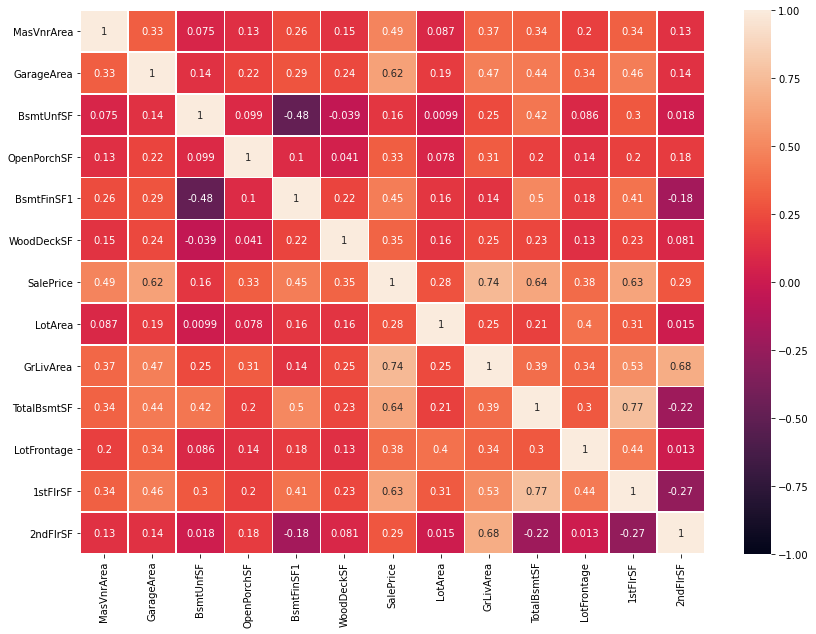

In [18]:
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, linewidths=.5, annot=True)

<b>Conclusion:</b> correlation between features is within reasonable values, no feature will be removed.

#### 1.2.9 Correlation Against Target Variable (SalePrice)<a class="anchor" id="catv"></a>

In [19]:
# Remove features with low correlation (<0.01) with the target variable(SalePrice)
corr_matrix['SalePrice'].abs().sort_values(ascending=False)

SalePrice      1.000000
GrLivArea      0.736036
TotalBsmtSF    0.642354
1stFlrSF       0.634672
GarageArea     0.621900
MasVnrArea     0.486620
BsmtFinSF1     0.454087
LotFrontage    0.382420
WoodDeckSF     0.350127
OpenPorchSF    0.326489
2ndFlrSF       0.293338
LotArea        0.275066
BsmtUnfSF      0.159724
Name: SalePrice, dtype: float64

<b>Conslusion:</b> no features will be removed since correlation between target variable and features is within reasonable values.


#### 1.2.10 Checking for Normality: Dependent Variable<a class="anchor" id="cndv"></a>

variable = y
Median: 159000.0
Mean: 175567.64318276005
Skew: 1.7453580480340125
Kurtosis: 5.825763749688768
--------------------------------------------------
variable = log10(y)
Median: 5.201397124320452
Mean: 5.244444479212366
Skew: 0.24188453291963574
Kurtosis: 0.7653528688452214


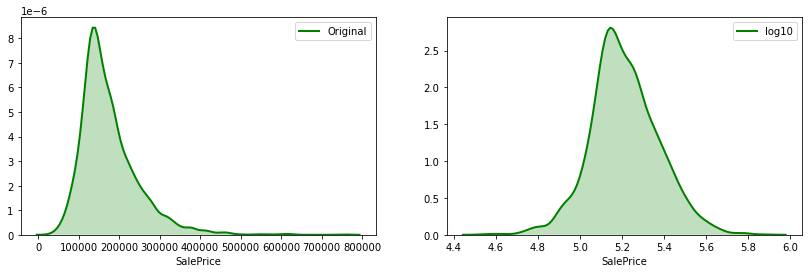

In [20]:
# Check Target variable for normal distribution
print('variable = y')
print("Median: " + str(dataset_encoded['SalePrice'].median()))
print("Mean: " + str(dataset_encoded['SalePrice'].mean()))
print("Skew: " + str(dataset_encoded['SalePrice'].skew()))
print("Kurtosis: " + str(dataset_encoded['SalePrice'].kurtosis()))
print("-"*50)
# log10
print("variable = log10(y)")
print("Median: " + str(np.log10(dataset_encoded['SalePrice'].median())))
print("Mean: " + str(np.log10(dataset_encoded['SalePrice'].mean())))
print("Skew: " + str(np.log10(dataset_encoded['SalePrice'].skew())))
print("Kurtosis: " + str(np.log10(dataset_encoded['SalePrice'].kurtosis())))
# creating axes to draw plots 
fig, ax = plt.subplots(1, 2, figsize=(14,4)) 
sns.distplot(dataset_encoded['SalePrice'], hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Original", color ="green", ax = ax[0]) 
sns.distplot(np.log10(dataset_encoded['SalePrice']), hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "log10", color ="green", ax = ax[1])


<b>Conclusion:</b> Calculating the log10 of the target variable produces a distribution closer to the normal distribution.

#### 1.2.11 Checking for Normality: Independent Variables<a class="anchor" id="cniv"></a>

In [21]:
# Continuous variables -> skewness
cont_var_skew = pd.DataFrame((dataset_encoded[continuous_variables_updated]).skew().abs()).reset_index()
cont_var_log_skew = pd.DataFrame(np.log10(dataset_encoded[continuous_variables_updated]+1).skew().abs()).reset_index()
cont_var_skew.columns = ['feature','skewness']
cont_var_log_skew.columns = ['feature','skewness_log']
cont_skew = cont_var_skew.merge(cont_var_log_skew, on="feature", how="inner")
cont_skew

,feature,skewness,skewness_log
0,MasVnrArea,2.750254,0.586703
1,GarageArea,0.192519,3.738757
2,BsmtUnfSF,0.978891,2.129723
3,OpenPorchSF,2.269634,0.000086
4,BsmtFinSF1,0.746737,0.738851
5,WoodDeckSF,1.884156,0.156027
6,SalePrice,1.745358,0.155859
7,LotArea,13.393921,0.513180
8,GrLivArea,0.940956,0.036984
9,TotalBsmtSF,0.456386,4.948562


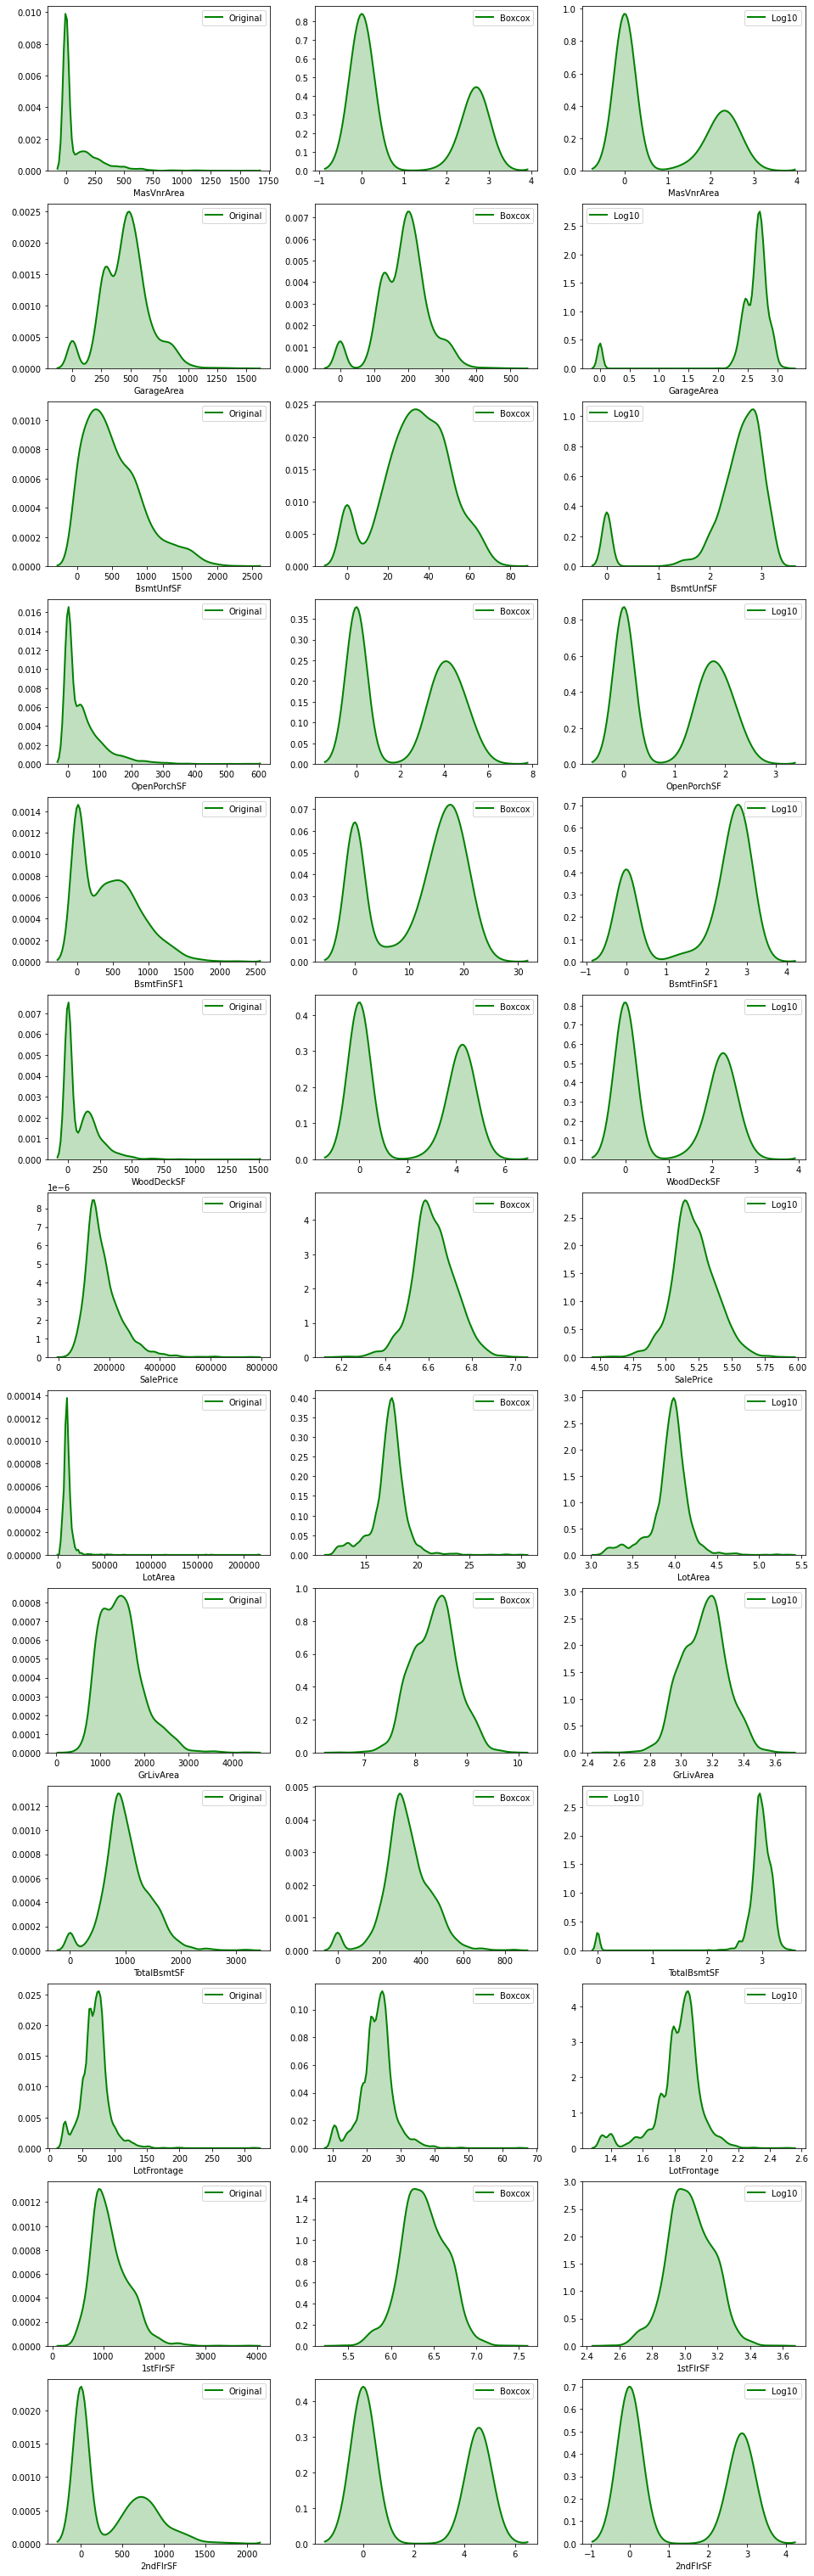

In [22]:
# creating axes to draw plots: 3 plots per feature
fig, ax = plt.subplots(dataset_encoded[continuous_variables_updated].shape[1], 3,  figsize=(16,55))
# Plot original data, boxcox, and log10
for i,feature in enumerate(continuous_variables_updated):
    original_data = dataset_encoded[feature]+1
    sns.distplot(original_data, hist = False, kde = True, 
                kde_kws = {'shade': True, 'linewidth': 2},  
                label = "Original", color ="green", ax = ax[i,0]) 

    fitted_data, fitted_lambda = stats.boxcox(original_data) 
    sns.distplot(fitted_data, hist = False, kde = True, 
                kde_kws = {'shade': True, 'linewidth': 2},  
                label = "Boxcox", color ="green", ax = ax[i,1]) 

    sns.distplot(np.log10(original_data), hist = False, kde = True, 
                kde_kws = {'shade': True, 'linewidth': 2},  
                label = "Log10", color ="green", ax = ax[i,2])

<b>Conclusion:</b> we will take the log10 of the following features: 1stFirSF, GrLivArea, and LotArea

In [23]:
# Take log10 of GrLivArea, LotArea, and 1stFlrSF
dataset_encoded['log10_GrLivArea'] = np.log10(dataset_encoded['GrLivArea'])
dataset_encoded['log10_LotArea'] = np.log10(dataset_encoded['LotArea'])
dataset_encoded['log10_1stFlrSF'] = np.log10(dataset_encoded['1stFlrSF']+1)     # +1 : This means we are adding bias, but is needed for zero
# Remove original columns
dataset_encoded.drop(columns=['GrLivArea','LotArea','1stFlrSF'], inplace=True)

<br><br>
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### 1.3 Feature Selection<a class="anchor" id="fs"></a>

#### 1.3.1 Using Lasso Regression to Select Features<a class="anchor" id="lasso"></a>

In [24]:
X = dataset_encoded.drop('SalePrice',axis=1)  # features
y = dataset_encoded['SalePrice']              # target
X_norm = MinMaxScaler().fit_transform(X)      # Transform features by scaling each feature to a given range (0,1).

In [25]:
# Using Lasso to select features
clf = LassoCV(alphas=np.arange(0.0001, 0.01)).fit(X_norm, y)   # set alpha low to ensure the features will have more relevance
importance = np.abs(clf.coef_)

In [26]:
# create dataframe Feature - Importance
features =[]
scores = []
for i, feature in enumerate(X.columns):
    if importance[i]>0:
        features.append(feature)
        scores.append(importance[i])
# dataframe
feature_score = pd.DataFrame.from_dict({"feature":features,"Score":scores})
feature_score

,feature,Score
0,LotFrontage,19396.116286
1,LotShape,2395.858510
2,Utilities,25157.472303
3,LandSlope,4872.239680
4,OverallQual,76229.547519
...,...,...
191,Heating_OthW,42788.920349
192,Heating_Wall,7539.939849
193,log10_GrLivArea,48709.821309
194,log10_LotArea,86795.491213


In [27]:
# top 20 features with highest importance value
lasso_generated_features = list(feature_score.sort_values(by="Score", ascending=False).head(20)['feature'])

In [28]:
lasso_generated_features 

['log10_1stFlrSF',
 'TotalBsmtSF',
 'Condition2_PosA',
 '2ndFlrSF',
 'Neighborhood_GrnHill',
 'log10_LotArea',
 'OverallQual',
 'RoofMatl_WdShngl',
 'Condition2_PosN',
 'MasVnrArea',
 'Exterior1st_PreCast',
 'YearBuilt',
 'GarageType_None',
 'log10_GrLivArea',
 'OverallCond',
 'Heating_OthW',
 'BsmtUnfSF',
 'BsmtCond',
 'Condition2_RRAn',
 'BedroomAbvGr']

<br><br>
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### 1.4 Descriptive Modeling<a class="anchor" id="dm"></a>

#### 1.4.1 Train and Test data<a class="anchor" id="ttd"></a>

In [29]:
# dataset -> Includes all features - Ordinal features encoded, Nominal features not dummified.
# dataset_encoded.shape -> Includes all features - Ordinal and Nominal features encoded/dummified.
# X -> Same as dataset_encoded without SalePrice feature
# Y -> Same as dataset_encoded but only SalePrice feature
# X_norm -> Same as X but all the numerical values scaled (0,1)

In [30]:
# Split data 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

#### 1.4.2 Multiple Linear Regression with all the features<a class="anchor" id="mlr"></a>

In [31]:
# Create model: Multiple Linear Regression
mlr_model = LinearRegression()
mlr_model.fit(X_train,np.log(y_train))

LinearRegression()

In [32]:
# # Calculate R-squared (score) using Training data
mlr_model.score(X_train,np.log(y_train))

0.9596248164084863

In [33]:
# Calculate R-squared (score) using Test data
mlr_model.score(X_test,np.log(y_test))

0.9353804149586213

#### 1.4.3 Multiple Linear Regresion with limited number of features<a class="anchor" id="mlr2"></a>

In [34]:
# Fit model with training data using Lasso generated features (top 20)
mlr_model.fit(X_train[lasso_generated_features], np.log10(y_train))
# Calculate R-squared (score) using training data
mlr_model.score(X_train[lasso_generated_features], np.log10(y_train))

0.920916295551426

In [35]:
# Calculate R-squared (score) using test data
mlr_model.score(X_test[lasso_generated_features], np.log10(y_test))

0.9182176601933645

In [36]:
# Coefficients for features
for i, name_c in enumerate(lasso_generated_features):
    print(name_c +":  " + "{:.6f}". format(mlr_model.coef_[i]))

log10_1stFlrSF:  0.230083
TotalBsmtSF:  0.000079
Condition2_PosA:  0.043557
2ndFlrSF:  0.000081
Neighborhood_GrnHill:  0.164508
log10_LotArea:  0.109813
OverallQual:  0.037370
RoofMatl_WdShngl:  0.004379
Condition2_PosN:  0.050021
MasVnrArea:  0.000027
Exterior1st_PreCast:  0.175791
YearBuilt:  0.001531
GarageType_None:  -0.028972
log10_GrLivArea:  0.221022
OverallCond:  0.022255
Heating_OthW:  -0.044454
BsmtUnfSF:  -0.000041
BsmtCond:  0.006394
Condition2_RRAn:  0.000000
BedroomAbvGr:  -0.014778


#### 1.4.4 Evaluating p-values and R-squared using Statmodels<a class="anchor" id="statmodel"></a>

In [37]:
# Statmodels does not like feature names starting with a number
X_stat = dataset_encoded.rename(columns={'2ndFlrSF':'FlrSF2nd'})
y_stat = dataset['SalePrice']
# Split data 70/30
X_train_stat, X_test_stat, y_train_stat, y_test_stat = train_test_split(X_stat, y_stat, test_size=0.30, random_state=10)
smf_model_features = lasso_generated_features
smf_model_features[3] = 'FlrSF2nd'

In [38]:
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('np.log10(SalePrice) ~ ' + ' + '.join(smf_model_features), data=X_train_stat).fit()

# Inspect the results
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log10(SalePrice)   R-squared:                       0.921
Model:                             OLS   Adj. R-squared:                  0.920
Method:                  Least Squares   F-statistic:                     1023.
Date:                 Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                         21:47:18   Log-Likelihood:                 2802.7
No. Observations:                 1689   AIC:                            -5565.
Df Residuals:                     1669   BIC:                            -5457.
Df Model:                           19                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             

In [39]:
# Decided to remove the following features whose Statistical Significance is low and some of the nominal features
smf_model_features = set(lasso_generated_features) - set(['Condition2_PosA','RoofMatl_WdShngl',
                                                          'Condition2_PosN','Heating_OthW','Condition2_RRAn'])#,'BsmtCond'])
                                                          #'Neighborhood_GrnHill','Exterior1st_PreCast','GarageType_None']) 

In [40]:
# Let's try again
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('np.log10(SalePrice) ~ ' + ' + '.join(smf_model_features), data=X_train_stat).fit()

# Inspect the results
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log10(SalePrice)   R-squared:                       0.921
Model:                             OLS   Adj. R-squared:                  0.920
Method:                  Least Squares   F-statistic:                     1295.
Date:                 Sun, 29 Nov 2020   Prob (F-statistic):               0.00
Time:                         21:47:18   Log-Likelihood:                 2800.2
No. Observations:                 1689   AIC:                            -5568.
Df Residuals:                     1673   BIC:                            -5482.
Df Model:                           15                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             

#### 1.4.5 Further narrowing of the number of features<a class="anchor" id="fnnf"></a>

In [41]:
import itertools

In [42]:
%%time
scores_models = {}
for features in itertools.combinations(smf_model_features, len(smf_model_features)-7):
    results = smf.ols('np.log10(SalePrice) ~ ' + ' + '.join(features), data=X_train_stat).fit()
    scores_models[features] = results.rsquared_adj

KeyboardInterrupt: 

In [43]:
Keymax = max(scores_models, key=scores_models.get) 
print(Keymax)

('MasVnrArea', 'FlrSF2nd', 'BsmtUnfSF', 'OverallCond', 'YearBuilt', 'log10_LotArea', 'log10_1stFlrSF', 'OverallQual')


In [44]:
scores_models[('BsmtUnfSF', 'TotalBsmtSF', 'log10_GrLivArea', 'BedroomAbvGr', 'OverallQual', 'OverallCond', 'YearBuilt', 'log10_LotArea')]

KeyError: ('BsmtUnfSF', 'TotalBsmtSF', 'log10_GrLivArea', 'BedroomAbvGr', 'OverallQual', 'OverallCond', 'YearBuilt', 'log10_LotArea')

In [ ]:
# Let's try again
results = smf.ols('np.log10(SalePrice) ~ ' + ' + '.join(['log10_GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'log10_LotArea', 'BsmtUnfSF', 'OverallCond', 'OverallQual']), data=dataset_encoded).fit()
# Inspect the results
print(results.summary())

<br><br><br><br>

<hr>

#### Linear Model

<b>Ava: </b>'BsmtQual', 'BsmtCond','BsmtFinType1', 'BsmtFinType1', 'BsmtUnfSF', 'TotalBsmtSF'

<b>Khamanna: </b>'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'GarageFinish', GarageQual', 'GarageCond',

<b>Ariel:</b>'OverallQual', 'OverallCond', 'PavedDrive', 'Fence', 'RoofStyle', 'RoofMatl',

<b>Shay: </b>'HeatingQC', 'CentralAir', 'KitchenAbvGr', 'KitchenQual', 'Fireplaces', 'FireplaceQu', 'LowQualFinSF'
 
y = beta0 + beta1*X1 + beta2*X2 + beta3*X3 + beta4*X4 ...+ betan*Xn(Exterior Quality)

1) Garage -> 'GarageFinish', 'GarageQual', 'GarageCond'
2) Exterior -> 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd'

1) Basement -> 'BsmtQual', 'BsmtCond','BsmtFinType1', 'BsmtFinType1', 'BsmtUnfSF', 'TotalBsmtSF'
2) 'Fireplaces', 'FireplaceQu', 

1) Overall Condition -> 'OverallQual', 'OverallCond', 
2) RoofStyle, RoofMatl

1) AC -> 'HeatingQC', 'CentralAir'
2) 'KitchenAbvGr', 'KitchenQual'
3) 'LowQualFinSF'

## Basement features

#### 1.2 check basement variable

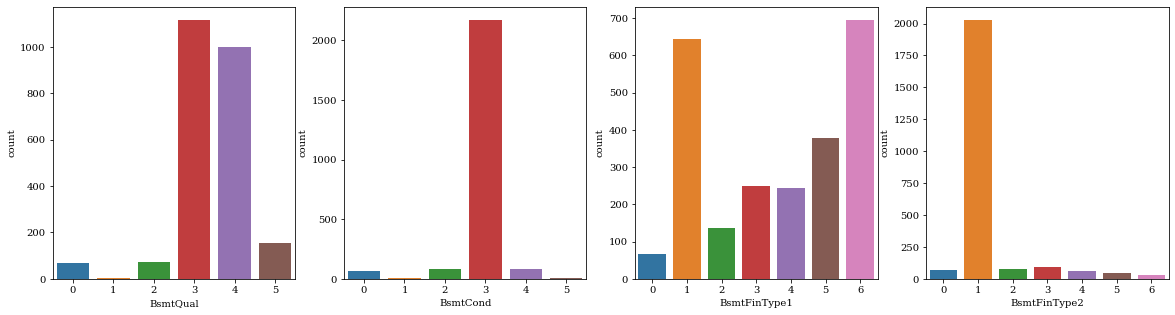

In [46]:
fig, ax =plt.subplots(1,4, figsize=(20,5))
sns.countplot(dataset['BsmtQual'], ax=ax[0])
sns.countplot(dataset['BsmtCond'], ax=ax[1])
sns.countplot(dataset['BsmtFinType1'], ax=ax[2])
sns.countplot(dataset['BsmtFinType2'], ax=ax[3])
plt.rcParams['figure.figsize'] = (10,2)
plt.rcParams['font.family'] = "serif"
fig.show()

In [47]:
dataset['TotalFinSF'] = dataset['TotalBsmtSF'] - dataset['BsmtUnfSF']

In [48]:
bsmt = dataset[['BsmtQual', 'BsmtCond', 'TotalBsmtSF','BsmtUnfSF','TotalFinSF','SalePrice']]

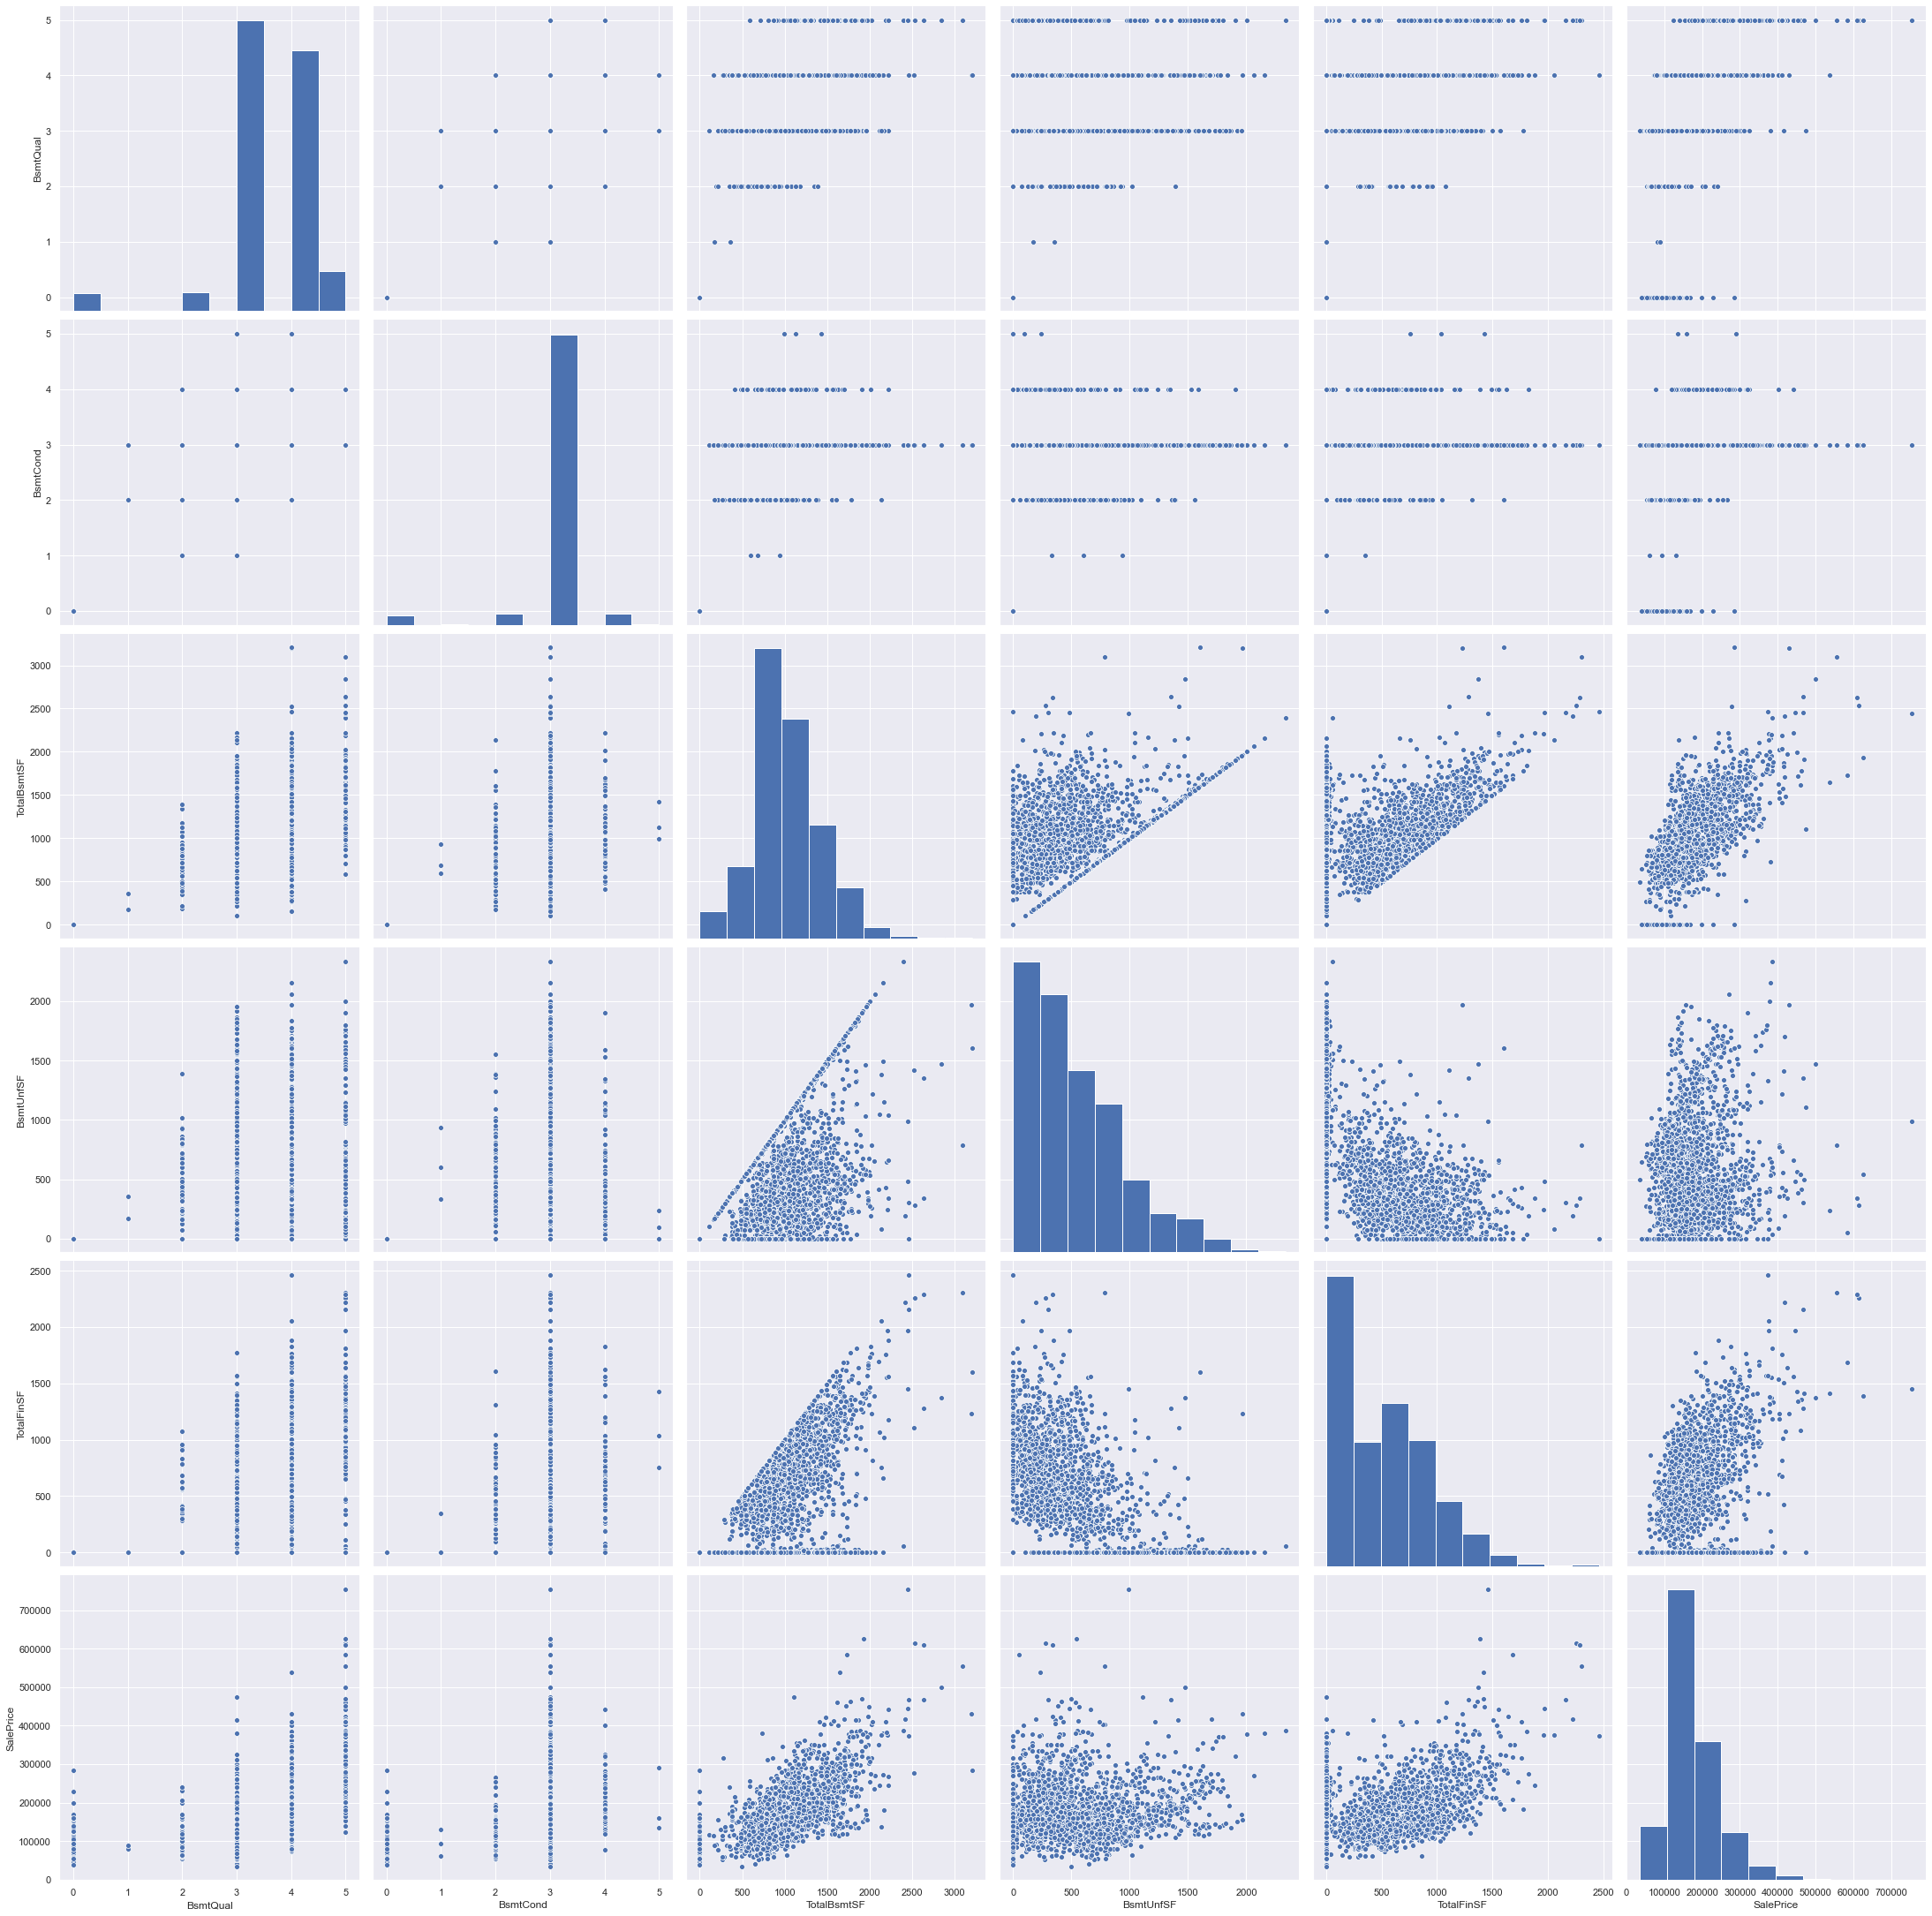

In [49]:
sns.set()
sns.pairplot(bsmt, size = 5.0)
plt.show();

#### 1.3 Check  correlation with Basement features and SalePrice

In [50]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
bsmt.corr()

,BsmtQual,BsmtCond,TotalBsmtSF,BsmtUnfSF,TotalFinSF,SalePrice
BsmtQual,1.000000,0.637998,0.561072,0.202220,0.327015,0.571877
BsmtCond,0.637998,1.000000,0.406627,0.165319,0.219340,0.208562
TotalBsmtSF,0.561072,0.406627,1.000000,0.423999,0.523003,0.642354
BsmtUnfSF,0.202220,0.165319,0.423999,1.000000,-0.550172,0.159724
TotalFinSF,0.327015,0.219340,0.523003,-0.550172,1.000000,0.441954
SalePrice,0.571877,0.208562,0.642354,0.159724,0.441954,1.000000


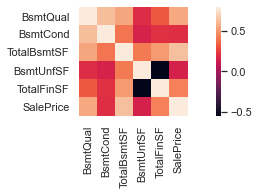

In [51]:
sns.heatmap(bsmt.corr(), vmax=.8, square=True)

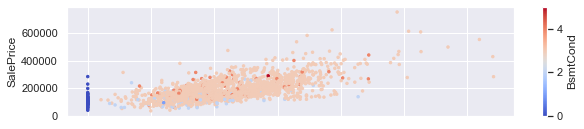

In [52]:
X_col = 'TotalBsmtSF'
y_col = 'SalePrice'
color_by = 'BsmtCond'
new_df = bsmt[[X_col,y_col,color_by]].copy()
new_df.plot.scatter(X_col,y_col, c=color_by, s=6, cmap='coolwarm')

In [53]:
bsmt = ['BsmtQual', 'BsmtCond','TotalBsmtSF','BsmtUnfSF','TotalFinSF','SalePrice']

## Evaluating Basement Condition


In [54]:
bsmt_con_dict = ({0:'No Basement', 1:'Poor',2:'Fair', 3:'Typical', 4:"Good", 5:"Excellent"})
bsmt_cond = dataset.groupby(['BsmtCond']).agg({"BsmtCond":"count"})
bsmt_cond.columns = ['Number of Houses']
bsmt_cond['Percentage of Houses'] = bsmt_cond['Number of Houses']/dataset.shape[0]*100
bsmt_cond.reset_index(inplace=True)
bsmt_cond.columns=["BsmtCond",'Number of Houses','Percentage of Houses']
bsmt_cond['BsmtCond'].replace(bsmt_con_dict, inplace=True)

In [55]:
bsmt_cond.style.applymap(lambda x: 'color: red' if (x<1.0) else 'color: black', subset=['Percentage of Houses']).hide_index()

BsmtCond,Number of Houses,Percentage of Houses
No Basement,67,2.776627
Poor,3,0.124327
Fair,84,3.481144
Typical,2170,89.929548
Good,86,3.564028
Excellent,3,0.124327


-  90% of the houses in our dataset has Typical, average condition basement. 

### Year built & Basement condition

In [56]:
Neighbor_year = dataset[['SalePrice', 'Neighborhood', 'YearBuilt', 'BsmtCond']]
# Neighbor_year['YearBuilt'].unique()[::10]
sorted(Neighbor_year['YearBuilt'].unique())[::10]

[1872, 1898, 1914, 1924, 1935, 1947, 1957, 1967, 1977, 1987, 1997, 2007]

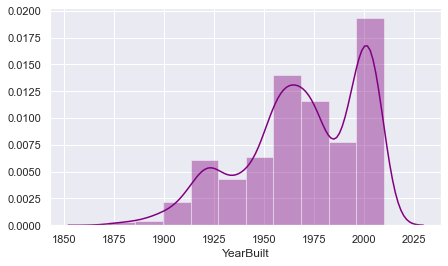

In [57]:
sns.set(rc={'figure.figsize':(7,4)})
sns.distplot(Neighbor_year['YearBuilt'], bins=10, color = "purple")

In [58]:
Neighbor_year1 = dataset[['YearBuilt','SalePrice', 'Neighborhood','BsmtCond']].copy()
def get(year):
    if year >= 2000:
        return "1990-2010"
    else:
        if year >= 1970:
            return "1970-1989"
        else:
            if year >= 1950:
                return "1950-1969"
            else:  
                if year >= 1930:
                    return "1930-1949"
                else:
                    if year >= 1900:
                        return "1900-1929"
                    else:
                        year < 1910
    return "1870-1910"

Neighbor_year1['YearBuilt'] = [get(year) for year in Neighbor_year1['YearBuilt']]

In [59]:
Year_count = Neighbor_year1.groupby(['YearBuilt']).agg({"Neighborhood":"count","BsmtCond":"mean","SalePrice":"mean"}).reset_index()
Year_count.columns = ['YearBuilt','Count','BsmtCond',"SalePrice"]
Year_count

,YearBuilt,Count,BsmtCond,SalePrice
0,1870-1910,24,2.708333,166290.791667
1,1900-1929,291,2.838488,127091.635739
2,1930-1949,222,2.702703,133781.162162
3,1950-1969,611,2.813421,147392.112930
4,1970-1989,746,3.022788,187998.719839
5,1990-2010,519,3.034682,236352.666667


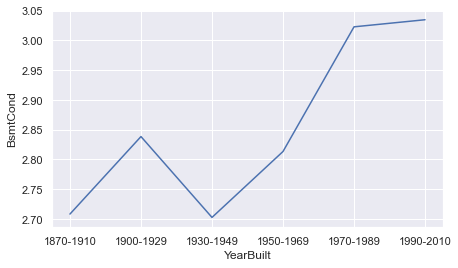

In [60]:
sns.lineplot( data=Year_count, x="YearBuilt", y="BsmtCond")

In [61]:
bsmt_con_year = Neighbor_year1 [['SalePrice', 'YearBuilt', 'BsmtCond']].copy()
bsmt_con_year['SalePrice'] = bsmt_con_year.SalePrice.astype(int)
def get(cond):
    if cond >= 3:
        return "above average"
    return "below average"

bsmt_con_year['BsmtCond'] = [get(cond) for cond in bsmt_con_year['BsmtCond']]
bsmt_con_year = bsmt_con_year.groupby(['YearBuilt', 'BsmtCond']).mean().reset_index()
bsmt_con_year

,YearBuilt,BsmtCond,SalePrice
0,1870-1910,above average,165421.052632
1,1870-1910,below average,169595.800000
2,1900-1929,above average,130831.341564
3,1900-1929,below average,108159.375000
4,1930-1949,above average,140169.326203
5,1930-1949,below average,99650.114286
6,1950-1969,above average,149853.218247
7,1950-1969,below average,120935.230769
8,1970-1989,above average,188544.399727
9,1970-1989,below average,157230.769231


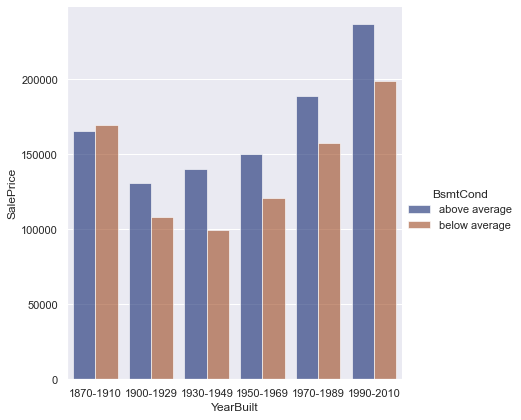

In [62]:
sns.catplot(data=bsmt_con_year, kind="bar",
    x='YearBuilt', y="SalePrice", hue="BsmtCond", 
    ci="sd", palette="dark", alpha=.6, height=6)

- Basement condition was better over 1970, the Sale Price was increased as well.

In [63]:
model_features = ['SalePrice','TotalBsmtSF', 'OverallQual', 'YearBuilt', 'log10_GrLivArea', 'OverallCond', 'log10_LotArea', 'BsmtUnfSF']

In [64]:
bsmt_con_dict = ({0:'No Basement', 1:'Poor',2:'Fair', 3:'Typical', 4:"Good", 5:"Excellent"})
dataset['BsmtCond'].replace(bsmt_con_dict, inplace=True)
dataset['BsmtFinType1'].replace(bsmt_con_dict , inplace=True)

In [65]:
# Dataset of Model Features + dummified Basement features
df_bsmtcond = pd.concat([dataset_encoded[model_features],pd.get_dummies(dataset['BsmtCond'])], axis=1)
df_bsmtcond.head(10)

,SalePrice,TotalBsmtSF,OverallQual,YearBuilt,log10_GrLivArea,OverallCond,log10_LotArea,BsmtUnfSF,Excellent,Fair,Good,No Basement,Poor,Typical
0,126000,856.0,6,1939,2.932474,6,3.897077,618.0,0,0,0,0,0,1
1,139500,1049.0,5,1984,3.020775,5,3.626853,104.0,0,0,0,0,0,1
2,124900,837.0,5,1930,3.000434,9,3.782473,100.0,0,0,0,0,0,1
3,114000,405.0,4,1900,3.016616,8,3.910944,405.0,0,0,0,0,0,1
4,227000,810.0,8,2001,3.221414,6,3.924279,167.0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2574,121000,952.0,6,1916,2.978637,6,3.947140,952.0,0,0,0,0,0,1
2575,139600,0.0,3,1955,3.238799,5,4.136086,0.0,0,0,0,1,0,0
2576,145000,1001.0,5,1949,3.301464,6,3.797268,717.0,0,0,0,0,0,1
2577,217500,985.0,7,2000,3.265290,5,3.945764,144.0,0,0,0,0,0,1


In [79]:
mlr_model_bsmt_cond = LinearRegression()
mlr_model_bsmt_cond.fit(df_bsmtcond .drop(columns=['SalePrice']), np.log10(df_bsmtcond ['SalePrice']))
mlr_model_bsmt_cond.score(df_bsmtcond .drop(columns=['SalePrice']), np.log10(df_bsmtcond ['SalePrice']))


0.9108383783315155

In [89]:
df_bsmtcond_test = df_bsmtcond.head(10)

,SalePrice,TotalBsmtSF,OverallQual,YearBuilt,log10_GrLivArea,OverallCond,log10_LotArea,BsmtUnfSF,Excellent,Fair,Good,No Basement,Poor,Typical
0,126000,856.0,6,1939,2.932474,6,3.897077,618.0,0,0,0,0,0,1
1,139500,1049.0,5,1984,3.020775,5,3.626853,104.0,0,0,0,0,0,1
2,124900,837.0,5,1930,3.000434,9,3.782473,100.0,0,0,0,0,0,1
3,114000,405.0,4,1900,3.016616,8,3.910944,405.0,0,0,0,0,0,1
4,227000,810.0,8,2001,3.221414,6,3.924279,167.0,0,0,0,0,0,1
5,198500,0.0,7,2003,3.283753,5,3.863382,0.0,0,0,0,1,0,0
6,93000,936.0,4,1953,2.971276,4,3.778151,936.0,0,0,0,0,0,1
8,137500,864.0,5,1984,2.948902,6,4.093247,217.0,0,0,0,0,0,1
9,140000,547.0,6,2005,3.030195,5,3.565257,80.0,0,0,0,0,0,1
10,219500,1342.0,8,2006,3.127753,5,3.795185,1318.0,0,0,0,0,0,1


In [91]:
for i in mlr_model_bsmt_cond.predict(df_bsmtcond_test.drop(columns=['SalePrice'])):
    print(10**i)

113429.95158710395
129340.61011473842
129082.78860213881
92443.56635370036
240970.45162264357
187481.22790703384
87688.65492864167
136040.59563789857
137339.8989222897
201439.4158390404


In [96]:
# Predict the sale price of a house with different exterior material == VinylSd
df_bsmtcond_test['Excellent']=1
df_bsmtcond_test['Good']=1
df_bsmtcond_test['Typical']=0
for i in mlr_model_bsmt_cond.predict(df_bsmtcond_test.drop(columns=['SalePrice'])):
    print(10**i)

107983.46668563686
123130.15449627236
122884.71261494295
88004.7697101475
229399.94570159857
181418.45290575086
83478.17146800073
129508.43160396238
130745.34717133654
191767.043404982


In [97]:
df_bsmtcond_test['Excellent']=0
df_bsmtcond_test['Good']=0
df_bsmtcond_test['Typical']=1
for i in mlr_model_bsmt_cond.predict(df_bsmtcond_test.drop(columns=['SalePrice'])):
    print(10**i)

113429.95158710395
129340.61011473842
129082.78860213881
92443.56635370036
240970.45162264357
190568.8617130106
87688.65492864167
136040.59563789857
137339.8989222897
201439.4158390404


### Basement Type

In [98]:
bsmt_type_dict = ({ 0:'No Basement', 1: 'Unfinshed', 2:'Low Quality' ,3:'Average Rec Room' ,\
                   4:'Below Average Living Quarters' ,5:'Average Living Quarters' ,6:'Good Living Quarters' })
dataset['YearBuilt_interval']= Neighbor_year1['YearBuilt']

In [99]:
bsmt_type_count=pd.DataFrame(dataset.groupby(['BsmtFinType1'])['SalePrice'].count()).reset_index()
bsmt_type_Price = pd.DataFrame(dataset.groupby('BsmtFinType1').agg({"SalePrice":"mean","GrLivArea":"mean"})\
.sort_values(by="SalePrice", ascending=False)).reset_index()
bsmt_type_price=pd.merge(bsmt_type_count,bsmt_type_Price , left_on='BsmtFinType1',right_on='BsmtFinType1', how='outer')
bsmt_type_price.columns = ['BsmtFinType','Count','SalePrice','GrLivArea']
bsmt_type_price['BsmtFinType'].replace(bsmt_type_dict, inplace=True)
bsmt_type_price.sort_values(by='SalePrice',ascending=False)

,BsmtFinType,Count,SalePrice,GrLivArea
0,Good Living Quarters,695,225545.225899,1606.100719
1,Excellent,378,164477.314815,1360.373016
5,Poor,644,160323.720497,1524.807453
2,Fair,136,152848.161765,1461.669118
3,Good,243,151971.707819,1336.987654
6,Typical,250,145724.816000,1363.952000
4,No Basement,67,109286.731343,1311.805970


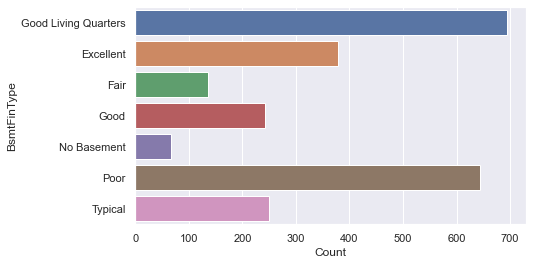

In [100]:
# fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(data = bsmt_type_price, x = 'Count', y='BsmtFinType')

In [111]:
dataset['BsmtFinType1'].replace(bsmt_type_dict , inplace=True)
df_bsmttype = pd.concat([dataset_encoded[['OverallQual', 'BedroomAbvGr', 'log10_GrLivArea', 'OverallCond',
                                      'YearBuilt', 'BsmtUnfSF', 'TotalBsmtSF','SalePrice',
                                      'log10_LotArea']],pd.get_dummies(dataset['BsmtFinType1'])], axis=1)
df_bsmttype.rename(columns={"BsmtFinType1":"BsmtFinType"}, inplace=True)

In [112]:
#Select 10 "Good Living Quarters" houses for our test
df_bsmttype_test = df_bsmttype[df_bsmttype['Good Living Quarters']==1].head(10)

In [113]:
# Model to evaluate Basement Type
mlr_model_bsmttype = LinearRegression()
mlr_model_bsmttype.fit(df_bsmttype.drop(columns=['SalePrice']), np.log10(df_bsmttype['SalePrice']))
mlr_model_bsmttype.score(df_bsmttype.drop(columns=['SalePrice']), np.log10(df_bsmttype['SalePrice']))

0.915095323146371

In [114]:
# Predict the sale price of a house with Basement Typel == Good Living Quarters
mlr_model_bsmttype.predict(df_bsmttype_test.drop(columns=['SalePrice']))

array([5.12122947, 5.38326606, 5.14714346, 5.31949802, 5.34927311,
       5.27701783, 5.12853476, 5.35033284, 5.18678213, 5.61319165])

In [115]:
results = []
for i, coef_ in enumerate(mlr_model_bsmttype.predict(df_bsmttype_test.drop(columns=['SalePrice']))):
    results .append(10**coef_)
results
bsmttype_good_predict = pd.DataFrame(results, columns = ['Good Living Quarters'])
bsmttype_good_predict

,Good Living Quarters
0,132199.397157
1,241694.105150
2,140327.716051
3,208688.260392
4,223497.725525
5,189242.132162
6,134441.936967
7,224043.752382
8,153738.320247
9,410385.161375


In [118]:
# Predict the sale price of a house with Basement Typel == Good Living Quarters
df_bsmttype_test['Unfinshed'] = 0
df_bsmttype_test['Good Living QuartersUnfinshed'] = 1
df_bsmttype_test['Exellent'] = 1

In [120]:
results = []
for i, coef_ in enumerate(mlr_model_bsmttype.predict(df_bsmttype_test.drop(columns=['SalePrice']))):
    results .append(int(10**coef_))
results
bsmt_unfi_predict = pd.DataFrame(results, columns = ['Unfinished Basement'])
bsmt_unfi_predict

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 15 is different from 18)

##### 1.5 check coeffeicient for Basement features

In [ ]:
#apply log(1+x) to sale price
bsmt1 = dataset[['Neighborhood','SalePrice','BsmtQual', 'BsmtCond', 'BsmtUnfSF', 'TotalBsmtSF','GrLivArea']]
bsmt1["SalePrice"] = np.log10(bsmt1["SalePrice"])

In [ ]:
mod = smf.ols(formula='SalePrice ~ TotalBsmtSF', data=bsmt1)
res = mod.fit()
print(res.summary())

In [ ]:
mod = smf.ols(formula='SalePrice ~ BsmtUnfSF', data=bsmt1)
res = mod.fit()
print(res.summary())

In [ ]:
mod = smf.ols(formula='SalePrice ~ BsmtQual + BsmtCond + BsmtUnfSF + TotalBsmtSF', data=bsmt1)
res = mod.fit()
print(res.summary())

- When we cehck coefficient for basement features and Saleprice, there are low relationship

## Fireplace features

### Number of fireplaces

In [ ]:
fig, ax =plt.subplots(1,2)
sns.countplot(dataset['Fireplaces'], ax=ax[0])
sns.countplot(dataset['FireplaceQu'], ax=ax[1])
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['font.family'] = "serif"
fig.show()

In [ ]:
fireplace = dataset[['Fireplaces', 'FireplaceQu','Neighborhood', "GrLivArea", "SalePrice",'YearBuilt_interval']]

In [ ]:
Fireplaces_dict = ({"0":'zero', "1":'one',"2":'two', "3":'three', "4":"four"})
Fireplaces_dict = ({0:'zero', 1:'one',2:'two', 3:'three', 4:"four"})

In [ ]:
Fireplaces_count = dataset.groupby(['Fireplaces']).agg({"Fireplaces":"count"})/dataset.shape[0]*100
Fireplaces_count.columns = ['Number of Houses']
Fireplaces_count.reset_index(inplace=True)
Fireplaces_count.columns=["Fireplaces",'Percentage of Houses']
Fireplaces_count
dataset['Fireplaces'].replace(Fireplaces_dict, inplace=True)

In [ ]:
Fireplaces_count = dataset.groupby(['Fireplaces']).agg({"Fireplaces":"count"})/dataset.shape[0]*100
Fireplaces_count.columns = ['Number of Houses']
Fireplaces_count.reset_index(inplace=True)
Fireplaces_count.columns=["Fireplaces",'Percentage of Houses']
Fireplaces_count

In [ ]:
df_Fireplaces = dataset_encoded[['OverallQual', 'BedroomAbvGr', 'log10_GrLivArea', 'OverallCond',
           'YearBuilt', 'BsmtUnfSF', 'TotalBsmtSF','SalePrice','log10_LotArea','Fireplaces']]

In [ ]:
df_Fireplaces = pd.concat([dataset_encoded[['OverallQual', 'BedroomAbvGr', 'log10_GrLivArea', 'OverallCond',
                                      'YearBuilt', 'BsmtUnfSF', 'TotalBsmtSF','SalePrice',
                                      'log10_LotArea']],pd.get_dummies(dataset['Fireplaces'])], axis=1)

In [ ]:
# Model to evaluate Fireplace 
mlr_model_Fireplaces = LinearRegression()
mlr_model_Fireplaces.fit(df_Fireplaces.drop(columns=['SalePrice']), np.log10(df_Fireplaces['SalePrice']))
mlr_model_Fireplaces.score(df_Fireplaces.drop(columns=['SalePrice']), np.log10(df_Fireplaces['SalePrice']))

In [ ]:
# Predict the sale price of a house with fireplace == zero
df_fireplace_test1 = df_Fireplaces[df_Fireplaces['zero']==1].head(10)
df_fireplace_test1 = df_Fireplaces[df_Fireplaces['one']==0].head(10)
mlr_model_Fireplaces.predict(df_fireplace_test1.drop(columns=['SalePrice']))

In [ ]:
#]for i in mlr_model_Fireplaces.predict(houses_to_predict.drop(columns=['SalePrice'])):
    print(10**i)

In [ ]:
results = []
for i, coef_ in enumerate(mlr_model_Fireplaces.predict(df_fireplace_test1.drop(columns=['SalePrice']))):
    results .append(int(10**coef_))
results
fireplace_no_predict = pd.DataFrame(results, columns = ['no fireplace'])
fireplace_no_predict

In [ ]:
# Predict the sale price of a house with bassement == one
df_fireplace_test = df_Fireplaces[df_Fireplaces['one']==1].head(10)
df_fireplace_test1 = df_Fireplaces[df_Fireplaces['zero']==0].head(10)
mlr_model_Fireplaces.predict(df_fireplace_test .drop(columns=['SalePrice']))

In [ ]:
results = []
for i, coef_ in enumerate(mlr_model_Fireplaces.predict(df_fireplace_test .drop(columns=['SalePrice']))):
    results .append(int(10**coef_))
results
fireplace_one_predict = pd.DataFrame(results, columns = ['1 fireplace'])
fireplace_one_predict

- Even thought the number of fireplace increases, the sale price doesn't effect. The house size will affect on this sale price

### check coefficient for fireplace variables

In [ ]:
#apply log(1+x) to sale price
firepl = dataset[['Neighborhood','SalePrice','Fireplaces', 'FireplaceQu']]
firepl["SalePrice"] = np.log10(firepl["SalePrice"])

In [ ]:
mod = smf.ols(formula='SalePrice ~ Fireplaces', data=firepl)
res = mod.fit()
print(res.summary())

In [ ]:
mod = smf.ols(formula='SalePrice ~ FireplaceQu', data=firepl)
res = mod.fit()
print(res.summary())